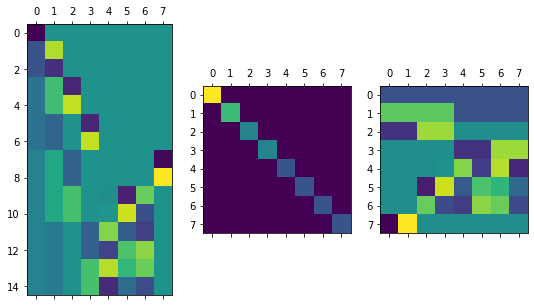

In [7]:
# demo simulation for NeurIPS 2020 paper: 
# Characterizing emergent representations in a space of candidate learning rules for deep networks
# Yinan Cao, Chris Summerfield, & Andrew Saxe
# Department of Experimental Psychology
# University of Oxford
# by Yinan Cao (y.cao@uke.de)

import numpy as np
import matplotlib.pyplot as plt

def svd(X):
  n, m = X.shape
  U, Sigma, Vh = np.linalg.svd(X, full_matrices = False, compute_uv = True)
  V = Vh.T
  S = np.diag(Sigma)
  return U, S, V

X = np.eye((8))
Y = np.array([
     [1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 1, 1, 1],
     [1, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 1, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 1],
     [1, 0, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 0, 0, 1]])
Cyx = np.dot(Y, X.T) # input-output structure
U, S, V = svd(Cyx)
Nf, Ni = np.shape(Y) # output neurons, items
Nx, Ni = np.shape(X) # input neurons, items
ns, ns = np.shape(S) # number of singular values

fig, axs = plt.subplots(1, 3, figsize=(9, 5), sharey=False)
axs[0].matshow(U)
axs[1].matshow(S)
axs[2].matshow(V.T)

In [8]:
lr = 0.005 # learning rate
gamma = 1 # top-down feedback
eta   = 0.001 # hebbian component
Nh = 32  # number of hidden units
maxEpoch = 15000 # maximum number of training epochs
ntime_samp = 25
time_sampled = np.round(np.linspace(0,maxEpoch-1,ntime_samp))
h_u = np.empty((Nh,Ni,ntime_samp), dtype=float)
count = 0
# print(time_sampled)

W0 = 1e-10 # small initial weight
W1 = np.random.normal(scale=W0, size=(Nh, Nx)) # 1st layer
W2 = np.random.normal(scale=W0, size=(Nf, Nh)) # 2nd layer
err = np.empty((maxEpoch,), dtype = float)
eff_SV = np.empty((maxEpoch,ns), dtype = float)

for epoch in range(maxEpoch):

  delta_W1_chl = np.zeros(np.shape(W1))
  delta_W2_chl = np.zeros(np.shape(W2))
  delta_W1_hebb = np.zeros(np.shape(W1))

  for item in range(Ni): # loop over items
    x = X[:,[item]]
    y = Y[:,[item]]
    y_hat = W2 @ W1 @ x # predicted output y
    h_ff  = np.dot(W1,x) # feedforward hidden-unit representation
    hc = h_ff + gamma * np.dot(W2.T,y) # clamped phase
    hf = h_ff + gamma * W2.T @ W2 @ W1 @ x # free phase

    delta_W1_chl += W2.T @ (y-y_hat) @ x.T
    delta_W2_chl += np.dot(y,hc.T) - np.dot(y_hat,hf.T)

    if eta >= 0: # Oja's rule for positive eta
      b = np.tile(x.T,(Nh,1)) - np.diagflat(h_ff)@W1
      a = np.tile(h_ff,(1,Nx))
      dW1vec = np.multiply(a, b)
    else:
      dW1vec = np.dot(h_ff, x.T)
    
    delta_W1_hebb += dW1vec # Hebbian update

  # end of object loop
  error = Y - W2@W1@X
  err[epoch] = np.linalg.norm(error, ord='fro')**2 # Sum squared training error
  eff_SV[epoch,:] = np.diag(U.T@W2@W1@V) # effective singular values
  
  if np.in1d(epoch, time_sampled):
    h_u[:,:,count] = W1@X # updated hidden-unit activity
    # print([epoch, count])
    count += 1

  # Weights updates:
  W2 += lr*delta_W2_chl # W2 update

  if eta >= 0:
    W1 += lr*delta_W1_chl + eta*delta_W1_hebb
  else: # normalize the update using the Euclidean norm for negative eta
    nn = np.linalg.norm(W1, ord=2, axis=1, keepdims=True) # L2 norm per neuron (row)
    nn = np.square(nn)
    a = eta*delta_W1_hebb
    b = np.tile(nn+1,(1,Nx))
    W1 += lr*delta_W1_chl + np.divide(a,b)

# end of epoch loop

3.8729833462082337
2.6457513110658106
1.7320508075709544
1.7320508075706402
1.000000000003432
1.0000000000033542
1.0000000000030629
1.0000000000058775


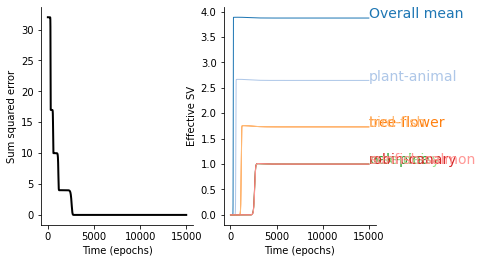

In [9]:
plt.close('all')

sv_end = np.empty([1,8])
sv_end = eff_SV[maxEpoch-1,:]

crange = np.linspace(0.1,1,ns)
majors = ['Overall mean','plant-animal','tree-flower','bird-fish','oak-pine','rose-daisy','robin-canary','sunfish-salmon']

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

ax = plt.subplot(1, 2, 1)
plt.plot(err, '-', color="black", lw=2)
plt.xlabel('Time (epochs)')
plt.ylabel('Sum squared error')
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)


ax = plt.subplot(1, 2, 2)
for k in range(ns):
  #print(np.abs(sv_end[k]-sv_end[k-1]))
  plt.plot(eff_SV[:,[k]], '-', lw=1, color=tableau20[k])
  if np.abs(sv_end[k]-sv_end[k-1])<0.05 and k > 0:
     dd = sv_end[k]
  else:
     dd = sv_end[k]
  print(dd)
  plt.text(maxEpoch, dd, majors[k], fontsize=14, color=tableau20[k])

plt.xlabel('Time (epochs)')
plt.ylabel('Effective SV')
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
plt.show()
